In [1]:
pip install shap xgboost

In [2]:
pip install plotly

In [3]:
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [4]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

In [5]:
print(X_display)

        Age          Workclass  Education-Num       Marital Status  \
0      39.0          State-gov           13.0        Never-married   
1      50.0   Self-emp-not-inc           13.0   Married-civ-spouse   
2      38.0            Private            9.0             Divorced   
3      53.0            Private            7.0   Married-civ-spouse   
4      28.0            Private           13.0   Married-civ-spouse   
...     ...                ...            ...                  ...   
32556  27.0            Private           12.0   Married-civ-spouse   
32557  40.0            Private            9.0   Married-civ-spouse   
32558  58.0            Private            9.0              Widowed   
32559  22.0            Private            9.0        Never-married   
32560  52.0       Self-emp-inc            9.0   Married-civ-spouse   

               Occupation    Relationship    Race      Sex  Capital Gain  \
0            Adm-clerical   Not-in-family   White     Male        2174.0   
1      

In [6]:
print(y_display)

[False False False ... False False  True]


In [7]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [8]:
print(X.shape)

(32561, 12)


In [9]:
print(X_train)

        Age  Workclass  Education-Num  Marital Status  Occupation  \
12011  51.0          4           10.0               0           6   
23599  51.0          1           14.0               6          12   
23603  21.0          4           11.0               4           3   
6163   25.0          4           10.0               4          12   
14883  48.0          4           13.0               0           1   
...     ...        ...            ...             ...         ...   
5699   23.0          4            9.0               4          12   
10742  37.0          4            9.0               2           7   
16921  27.0          6            5.0               2           3   
25796  46.0          4           16.0               2          10   
28847  55.0          4           10.0               0          13   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
12011             0     4    0           0.0           0.0            40.0   
23599          

In [10]:
print(X_train.shape)

(26048, 12)


In [11]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.54663
[100]	test-logloss:0.36398
[200]	test-logloss:0.31758
[300]	test-logloss:0.30065
[400]	test-logloss:0.29170
[500]	test-logloss:0.28655
[600]	test-logloss:0.28358
[700]	test-logloss:0.28174
[800]	test-logloss:0.28061
[900]	test-logloss:0.27988
[1000]	test-logloss:0.27939
[1100]	test-logloss:0.27906
[1178]	test-logloss:0.27887


In [12]:
from sklearn.metrics import accuracy_score

# Make predictions
y_pred_prob = model.predict(d_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 87.49%


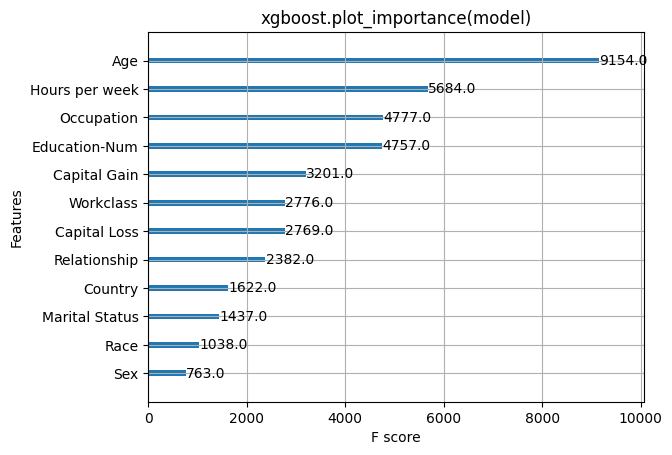

In [13]:
xgboost.plot_importance(model,importance_type="weight")
pl.title("xgboost.plot_importance(model)")
pl.show()

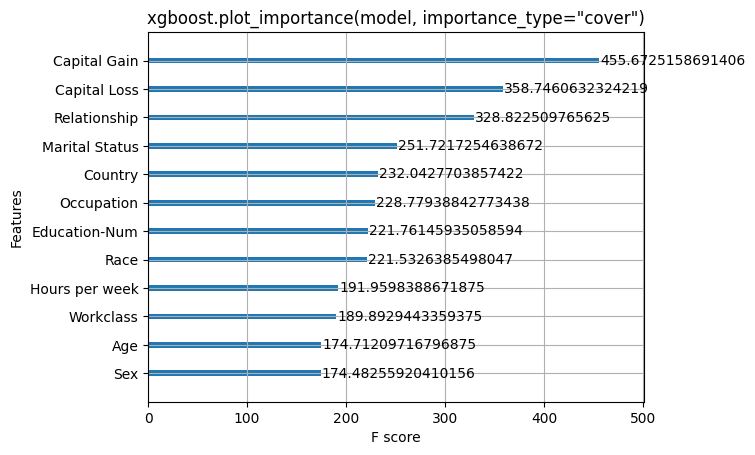

In [14]:
#The "cover" metric measures the coverage of a feature, which is the number of
#samples or observations that are affected by splits involving that feature.
#Essentially, it represents how frequently a feature is used to partition
#the data and how many data points fall into those partitions.

xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

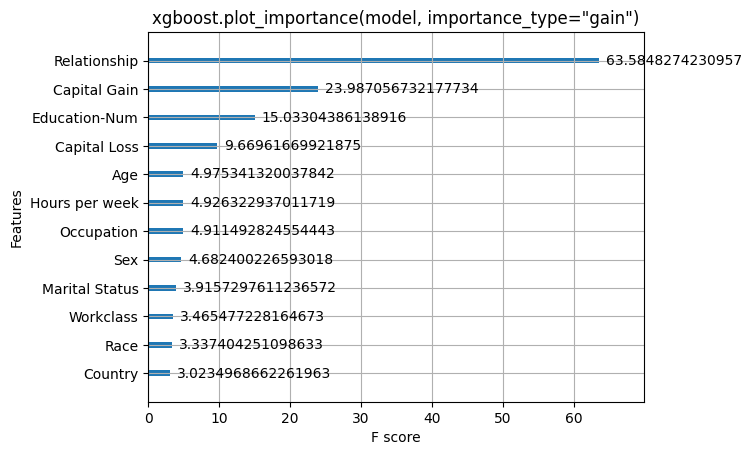

In [15]:
#Gain represents the improvement in the objective function (such as accuracy or log loss)
#that a feature provides when it is used in a split. It quantifies the
#contribution of a feature to the model's performance.

xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

In [17]:
# This takes 5-6 minutes since we are explaining over 30
#thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [19]:
import plotly.io as pio

# Set the default renderer for Plotly to 'colab'
pio.renderers.default = 'colab'

# print the JS visualization code to the notebook
shap.initjs()  # Ensure this line is uncommented

shap.force_plot(explainer.expected_value, shap_values[100, :], X_display.iloc[100, :])

In [20]:
# Set the default renderer for Plotly to 'colab'
pio.renderers.default = 'colab'

# print the JS visualization code to the notebook
shap.initjs()  # Ensure this line is uncommented

shap.force_plot(
    explainer.expected_value, shap_values[:1000, :], X_display.iloc[:1000, :]
)

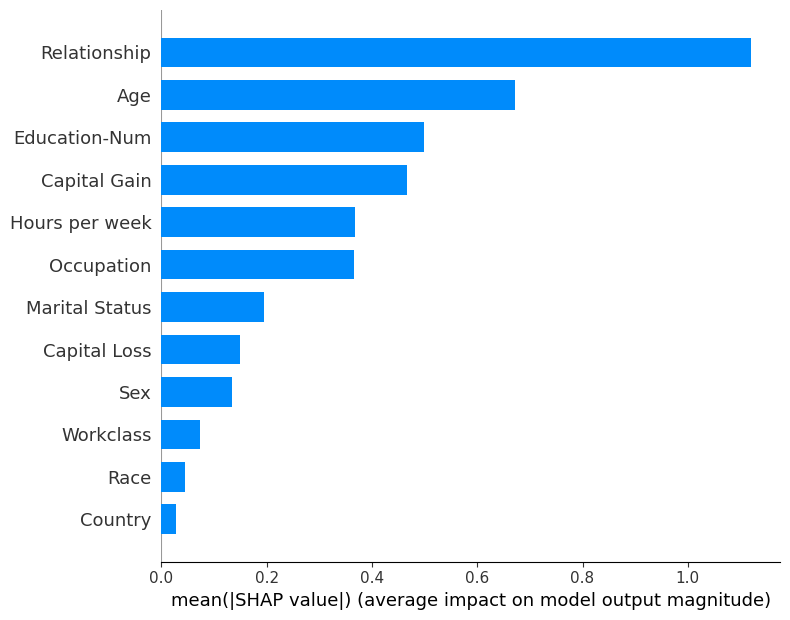

In [21]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

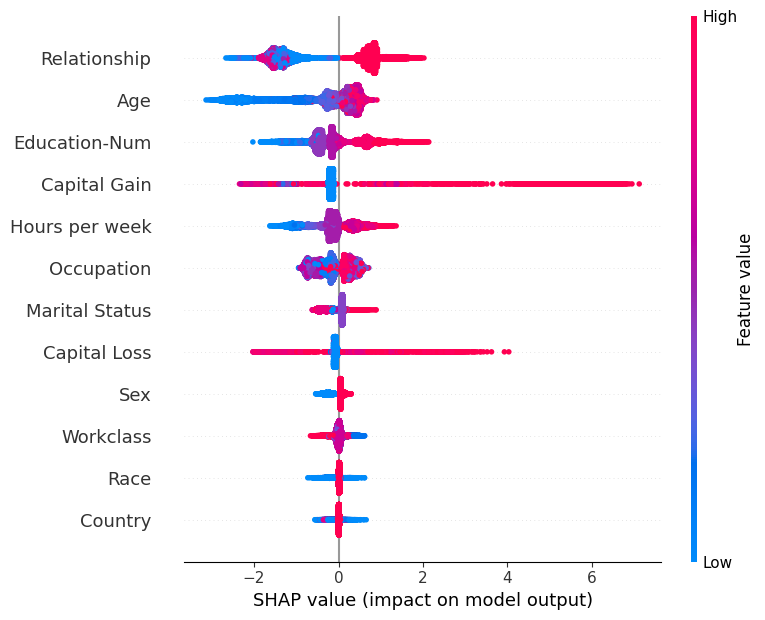

In [22]:
shap.summary_plot(shap_values, X)

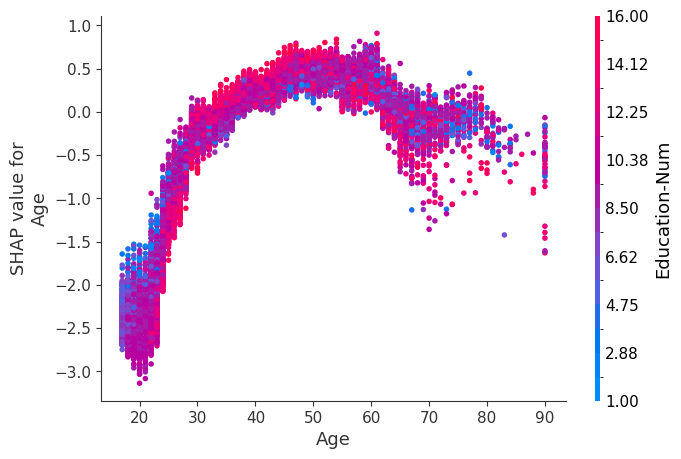

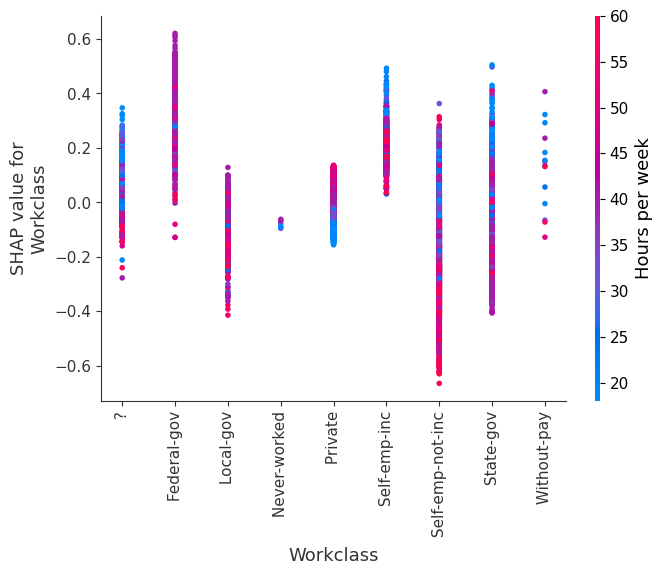

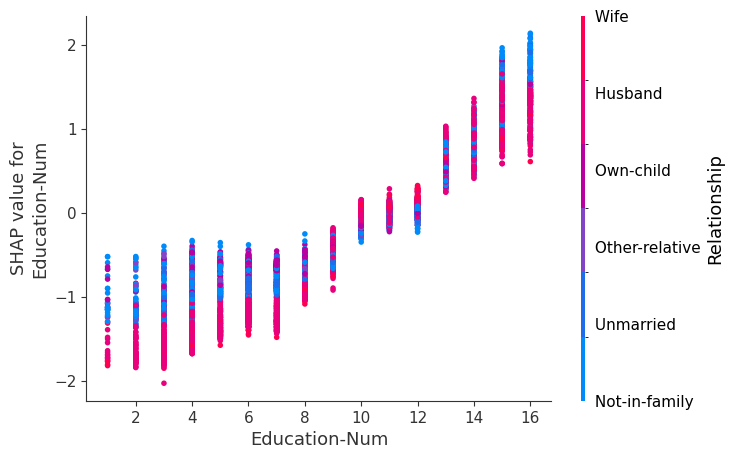

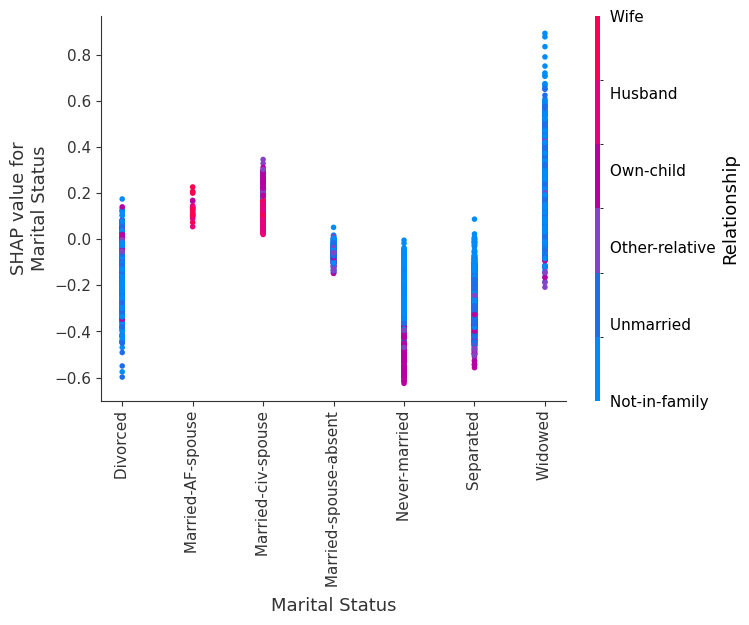

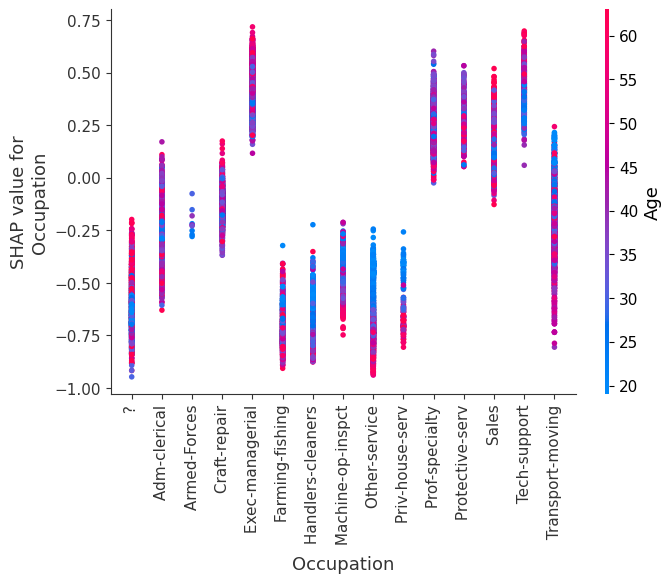

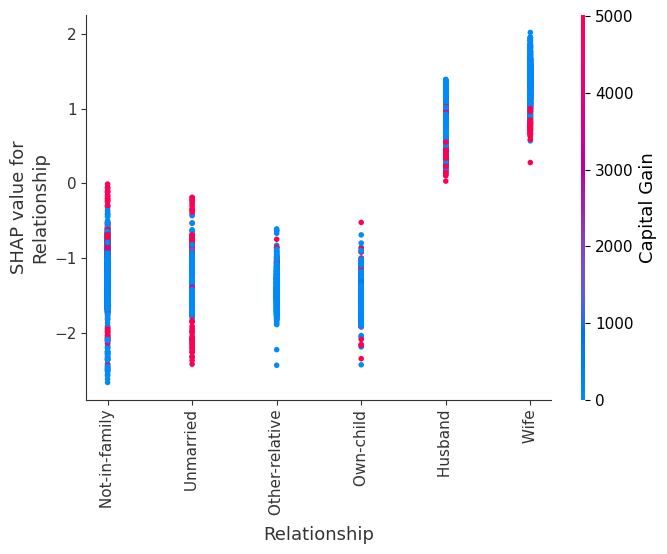

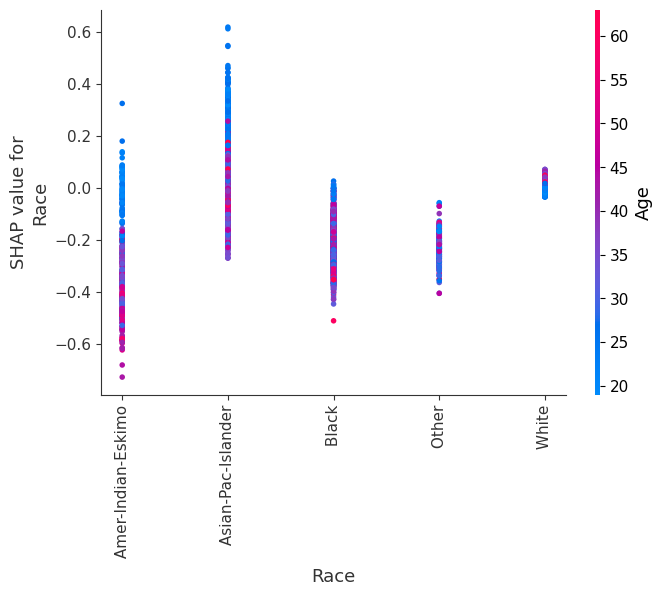

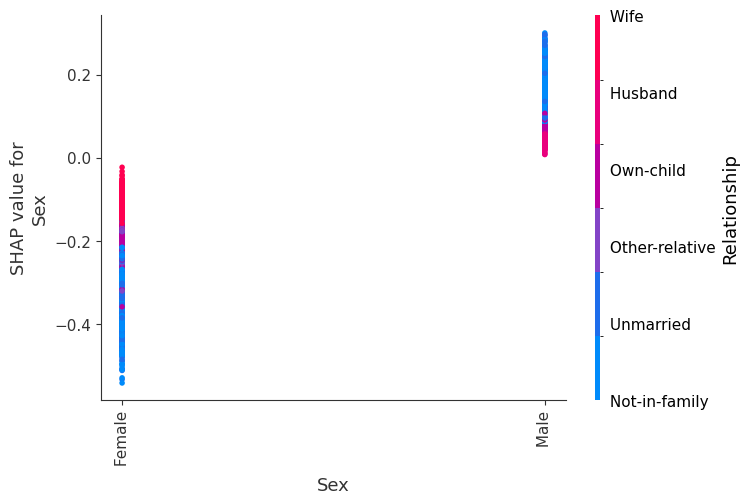

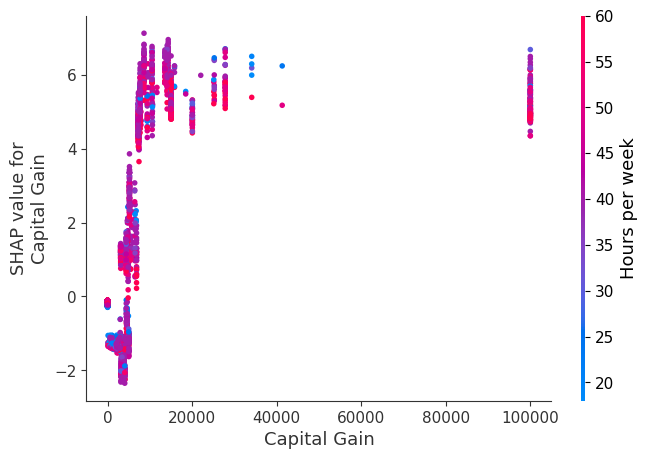

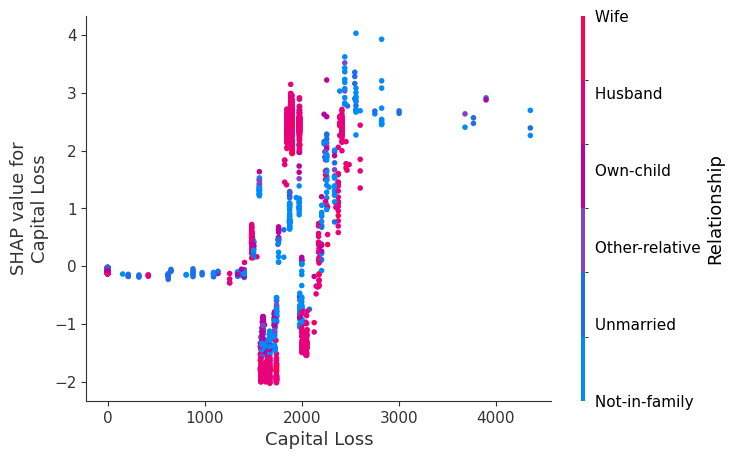

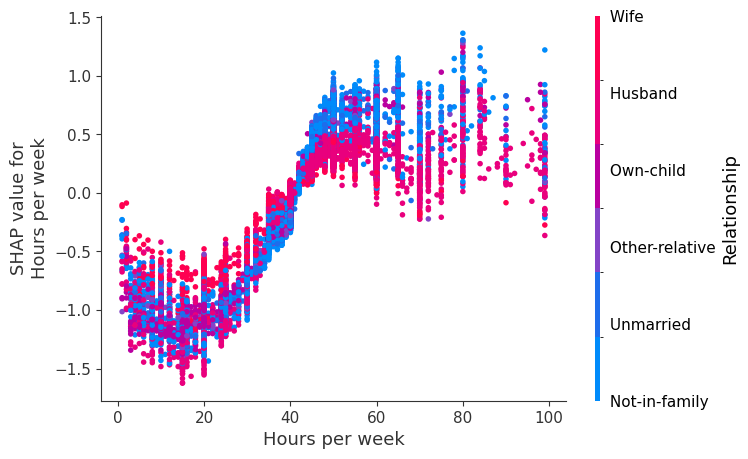

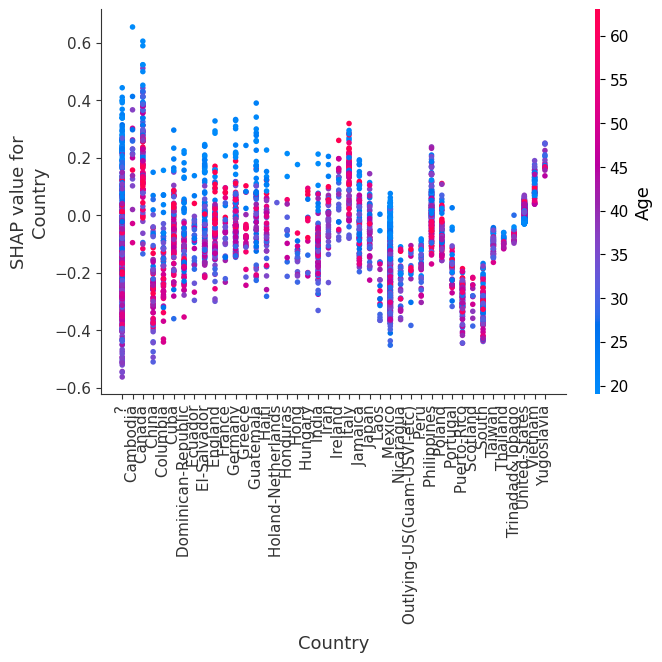

In [23]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)